In [194]:
from queries import*
from utilities import*

In [195]:
#!pip install networkx==2.5.0 python-louvain

In [196]:
#nx.__version__

## Read data :

### Nodes 

In [197]:
nodes = pd.read_csv('data/nodes_with_border.csv')
                    
### Setting cell_id as index

nodes.set_index('cell_id', inplace=True)


In [198]:
nodes.head(2)

,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
cell_id,,,,,
1,14040.7,37383.4,stroma,stroma,False
2,14049.6,37381.9,stroma,MISSING,False


In [199]:
nodes.phenotype.unique()

array(['stroma', 'MISSING', 'tumor', 'T', 'macrophages', 'dendtritic',
       'B', 'NK'], dtype=object)

In [200]:
nodes.columns

Index(['cell_x_position', 'cell_y_position', 'tissue_category', 'phenotype',
       'on_border'],
      dtype='object')

### Edges

In [201]:
### Importing edges with distance threshold 100

edges = pd.read_csv('./data/edges_border.csv')

#### Fixing distance threshold and removing tumor border

THRESHOLD = 50

edges = graph_wrangling(edges,THRESHOLD, only_border = True)


In [202]:
edges.head(5)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,is_border
2,40.121441,35764,35871,stroma,tumor,T,tumor,True
3,41.571384,35764,35864,stroma,tumor,T,tumor,True
6,45.496483,44539,44711,stroma,tumor,T,T,True
14,39.936199,3538,3785,tumor,stroma,stroma,T,True
16,48.097505,3915,3947,tumor,stroma,stroma,stroma,True


In [203]:
len(edges[edges.is_border ==True])

83286

## Building the graph

In [204]:
cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
describe_graph(cell_graph)

Name: 
Type: Graph
Number of nodes: 22123
Number of edges: 83287
Average degree:   7.5294
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0003
Global clustering coefficient aka Transitivity: 0.0002


### Adding singular edges

### Degree distribution

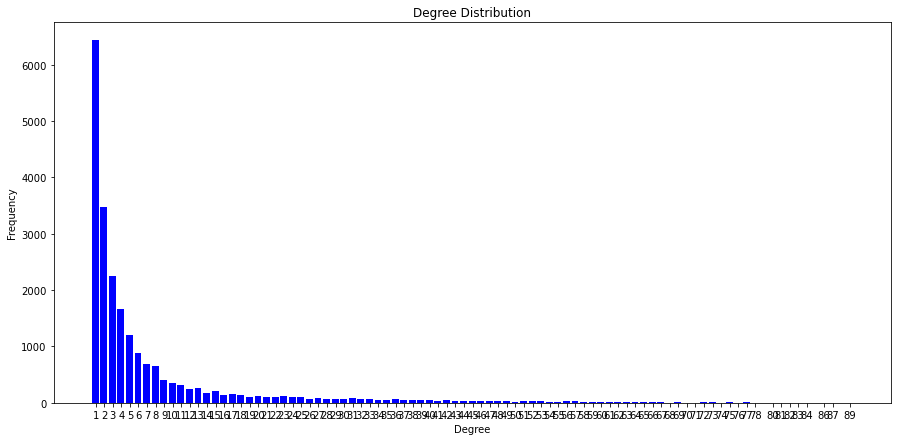

In [205]:
plot_degree_distribution(cell_graph)

### Adding nodes attributes

In [206]:
nx.set_node_attributes(cell_graph, nodes['cell_x_position'].to_dict(), 'x_position' )
nx.set_node_attributes(cell_graph, nodes['cell_y_position'].to_dict(), 'y_position' )
nx.set_node_attributes(cell_graph, nodes['tissue_category'].to_dict(), 'tissue_category' )
nx.set_node_attributes(cell_graph, nodes['phenotype'].to_dict(), 'phenotype' )
nx.set_node_attributes(cell_graph, nodes['on_border'].to_dict(), 'border' )


In [207]:
cell_graph.nodes[35980]

{'x_position': 18883.2,
 'y_position': 38730.0,
 'tissue_category': 'tumor',
 'phenotype': 'tumor',
 'border': True}

### Connected components

In [208]:
components = list(nx.connected_components(cell_graph))
print('The cell graph contains', len(components), 'connected components')

The cell graph contains 124 connected components


In [209]:
largest_comp = max(components, key=len)
percentage_lcc = len(largest_comp)/cell_graph.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')

The largest component has 2418 nodes accounting for 10.93 % of the nodes


### Filtering components

In [210]:
MIN_ELEMENTS_PER_CLUSTER = 1
components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
components = sorted(components, key=len, reverse=False)

In [211]:
len(components)

124

In [212]:
subgraphs = [cell_graph.subgraph(c).copy() for c in components]

In [25]:
for index, component in enumerate(subgraphs):
    print('Component number :', index)
    print(nx.info(component))

Component number : 0
Name: 
Type: Graph
Number of nodes: 304
Number of edges: 1033
Average degree:   6.7961
Component number : 1
Name: 
Type: Graph
Number of nodes: 329
Number of edges: 1202
Average degree:   7.3070
Component number : 2
Name: 
Type: Graph
Number of nodes: 331
Number of edges: 1189
Average degree:   7.1843
Component number : 3
Name: 
Type: Graph
Number of nodes: 401
Number of edges: 1531
Average degree:   7.6359
Component number : 4
Name: 
Type: Graph
Number of nodes: 597
Number of edges: 3985
Average degree:  13.3501
Component number : 5
Name: 
Type: Graph
Number of nodes: 608
Number of edges: 4612
Average degree:  15.1711
Component number : 6
Name: 
Type: Graph
Number of nodes: 619
Number of edges: 3051
Average degree:   9.8578
Component number : 7
Name: 
Type: Graph
Number of nodes: 846
Number of edges: 2715
Average degree:   6.4184
Component number : 8
Name: 
Type: Graph
Number of nodes: 1028
Number of edges: 7415
Average degree:  14.4261
Component number : 9
Name: 

In [213]:
map_to_component = {}

for index, component in enumerate(components) :
    
    elements_component = list(component)
    for element in elements_component:
        
        map_to_component[element] = index

    

In [214]:
nodes['component'] = nodes.reset_index()['cell_id'].apply(lambda x: map_to_component[x]if x in map_to_component.keys() else '')

## Plotting nodes

### Differentiating components

In [52]:
#vis_nodes = nodes[nodes.phenotype != 'stroma']
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component').get_figure().savefig('./plots/scatter_component_no_stroma.png')

### Differentiating Tissue

In [53]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma') & (nodes.phenotype != 'tumor') & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component', cmap =sns.color_palette("tab10")).get_figure().savefig('./plots/scatter_only_components.png')

In [55]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma') & (nodes.phenotype != 'tumor') & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype',
                #cmap =sns.color_palette("tab10")).get_figure().savefig('./plots/scatter_phenotype_no_stroma_no_tumor.png')

## plotting component graphs

In [109]:
def get_subnodes(G , attribute, value):
    
    nodes_list = []
    
    for n in G.nodes():
        if G.nodes[n][attribute] == value :
            
            nodes_list.append(n)
            
    return nodes_list        

In [177]:
def visualize_graph(G, with_labels=False, k=None, alpha=0.1, color_attribute ='phenotype' ,node_shape='.',bipartite = False, savefig =False, figname =''):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    fig = plt.figure(figsize=(30,20))

    tumor_nodes = get_subnodes(G, 'phenotype','tumor')
    color_mapping = {'tumor':'darkred', 'stroma':'peru', 'T':'springgreen', 
                     'B':'turquoise','macrophages':'khaki', 'dendtritic':'orange', 'NK':'gray', 'MISSING' :'slategray'}
    if bipartite:
        pos = nx.bipartite_layout(G, tumor_nodes ,align ='vertical')
     
    else:
        pos = nx.spring_layout(G)
    
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes() ,node_color=[color_mapping[G.nodes[n][color_attribute]] for n in G.nodes()], 
                             alpha=0.8, node_shape = node_shape)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    if savefig:
        fig.savefig('./plots/'+figname)
        
    

    
    

In [180]:
def plot_component(graph, MIN_ELEMENTS_PER_CLUSTER= 200,component_number = 0 ,remove_stroma =False, bipartite =False, savefig=False, figname=''):
    
    components = list(nx.connected_components(graph))
    components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
    print('The cell graph contains', len(components), 'connected components')
    components = sorted(components, key=len, reverse=False)
    subgraphs = [cell_graph.subgraph(c).copy() for c in components]
    main_component = subgraphs[component_number]
    if remove_stroma :
        nodes_list =[]
        for n in main_component.nodes():
            if main_component.nodes[n]["phenotype"] != 'stroma' :
                nodes_list.append(n) 
        main_component =main_component.subgraph(nodes_list)
        
   # print(nx.info(main_component))
    visualize_graph(main_component,bipartite=bipartite, savefig=savefig, figname=figname)

    
 

In [190]:
MIN_NUMBER_PER__COMPONENT = 300
COMPONENT_NUM = 8
REMOVE_STROMA = True
BIPARTITE = False
SAVE_FIG = True
FIG_NAME ='component_8_without_stroma'

In [192]:
#plot_component(cell_graph,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#              remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#               savefig=SAVE_FIG, figname=FIG_NAME)

## Component analysis

Since it is a bipartite graph, we are only considering the border

In [221]:
nodes.component.value_counts()

       43410
123     2418
122     1901
121     1162
120     1071
       ...  
4          3
3          3
2          2
1          2
0          2
Name: component, Length: 125, dtype: int64

In [ ]:
component_df = 